In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image

SEED = 42
ROOT = Path(".")

# 대표샘플 csv (MetalSet 대표 271)
rep_csv = ROOT / "manifest_MetalSet_rep271_PCA_UMAP_KMeans.csv"
man_metal_rep = pd.read_csv(rep_csv)

# StdMetal target manifest (폴더에서 읽기)
SET_B = "StdMetal"
EXT = ".png"

def list_ids(set_dir: Path, mod: str) -> set:
    paths = list((set_dir / mod).rglob(f"*{EXT}"))
    return {p.stem for p in paths}

def build_manifest(set_name: str, mod="target") -> pd.DataFrame:
    set_dir = ROOT / set_name
    ids = sorted(list_ids(set_dir, mod))
    return pd.DataFrame({
        "set": set_name,
        "base_id": ids,
        "target": [str(set_dir / mod / f"{i}{EXT}") for i in ids]
    })

man_std = build_manifest(SET_B, mod="target")

print("MetalSet rep:", len(man_metal_rep))
print("StdMetal:", len(man_std))
man_metal_rep.head()


MetalSet rep: 271
StdMetal: 271


,set,base_id,target,cluster
0,MetalSet,cell2867,MetalSet\target\cell2867.png,0
1,MetalSet,cell121,MetalSet\target\cell121.png,0
2,MetalSet,cell5949,MetalSet\target\cell5949.png,0
3,MetalSet,cell941,MetalSet\target\cell941.png,1
4,MetalSet,cell3957,MetalSet\target\cell3957.png,1


In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image

SEED = 42
rng = np.random.default_rng(SEED)

ROOT = Path(".")
SET_A = "MetalSet"
SET_B = "StdMetal"
EXT = ".png"

DS_SIZE = 256
BIN_THR_TARGET = 0.5

# --- your utilities (reuse) ---
def load_gray(path: Path) -> np.ndarray:
    img = Image.open(path).convert("L")
    arr = np.asarray(img, dtype=np.float32)
    if arr.max() > 1.0:
        arr /= 255.0
    return arr

def downsample_nearest(bin_img: np.ndarray, size=256) -> np.ndarray:
    pil = Image.fromarray((bin_img * 255).astype(np.uint8))
    pil = pil.resize((size, size), resample=Image.NEAREST)
    return (np.asarray(pil) > 0).astype(np.uint8)

def binarize_fixed(x: np.ndarray, thr=0.5, auto_invert=True) -> np.ndarray:
    b = (x >= thr).astype(np.uint8)
    if auto_invert and b.mean() > 0.5:
        b = 1 - b
    return b

def list_ids(set_dir: Path, mod: str) -> set:
    folder = set_dir / mod
    paths = list(folder.rglob(f"*{EXT}"))
    return {p.stem for p in paths}

def build_manifest(set_name: str, mods=("target",)) -> pd.DataFrame:
    set_dir = ROOT / set_name
    if not set_dir.exists():
        raise RuntimeError(f"Dataset dir not found: {set_dir.resolve()}")
    id_sets = {m: list_ids(set_dir, m) for m in mods}
    common = set.intersection(*[id_sets[m] for m in mods])
    if len(common) == 0:
        raise RuntimeError(f"{set_name}: no common ids for mods={mods}")
    rows = []
    for bid in sorted(common):
        row = {"set": set_name, "base_id": bid}
        for m in mods:
            row[m] = str(set_dir / m / f"{bid}{EXT}")
        rows.append(row)
    return pd.DataFrame(rows)

def load_bin_target(path_str: str, thr=BIN_THR_TARGET, size=DS_SIZE) -> np.ndarray:
    x = load_gray(Path(path_str))
    b = binarize_fixed(x, thr, auto_invert=True)
    b = downsample_nearest(b, size=size)
    return b  # uint8 0/1 (H,W)

# --- manifests ---
# MetalSet 대표 271 csv (이미 만들어둔 결과)
rep_csv = ROOT / "manifest_MetalSet_rep271_PCA_UMAP_KMeans.csv"
if not rep_csv.exists():
    raise RuntimeError(f"Representative CSV not found: {rep_csv.resolve()}")

man_metal_rep = pd.read_csv(rep_csv)
if "target" not in man_metal_rep.columns:
    raise RuntimeError("CSV must contain 'target' column with file paths")

# StdMetal은 target 전체(271) 사용
man_std = build_manifest(SET_B, mods=("target",))

print("MetalSet reps:", len(man_metal_rep))
print("StdMetal:", len(man_std))
print("Example Metal target:", man_metal_rep["target"].iloc[0])
print("Example Std target:", man_std["target"].iloc[0])


MetalSet reps: 271
StdMetal: 271
Example Metal target: MetalSet\target\cell2867.png
Example Std target: StdMetal\target\AND2_X4__0_0.png


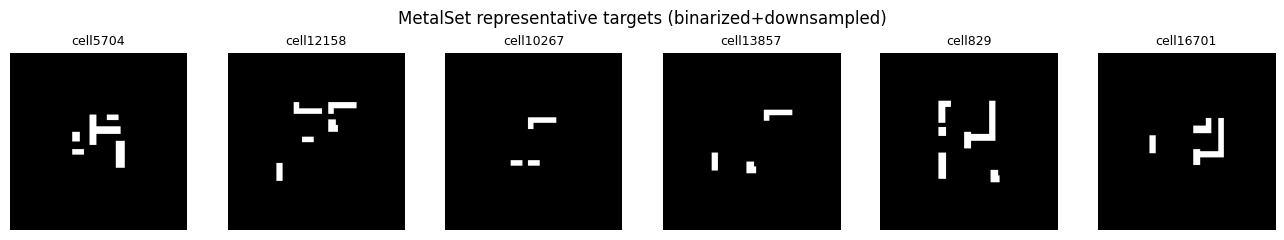

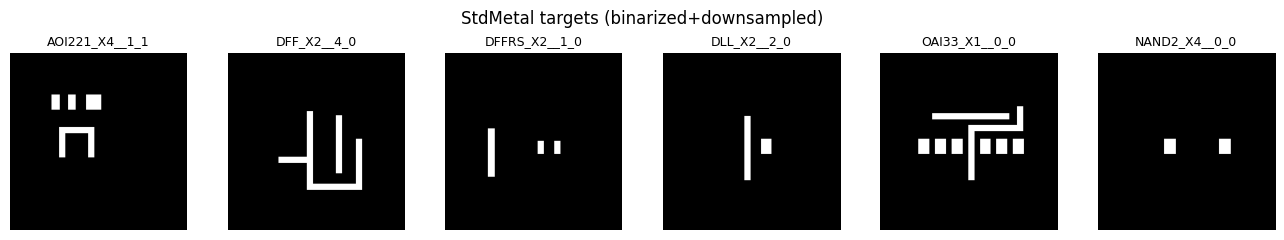

In [4]:
import matplotlib.pyplot as plt

def show_random_targets(df, k=6, title=""):
    samp = df.sample(min(k, len(df)), random_state=SEED)
    fig, axes = plt.subplots(1, len(samp), figsize=(2.2*len(samp), 2.4))
    if len(samp) == 1:
        axes = [axes]
    for ax, (_, r) in zip(axes, samp.iterrows()):
        b = load_bin_target(r["target"])
        ax.imshow(b, cmap="gray")
        ax.set_title(r.get("base_id", ""), fontsize=9)
        ax.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_random_targets(man_metal_rep, k=6, title="MetalSet representative targets (binarized+downsampled)")
show_random_targets(man_std, k=6, title="StdMetal targets (binarized+downsampled)")


In [5]:
# Cell 2-1: density sanity check (auto_invert 과발동 여부 확인)
def density_of(path_str):
    b = load_bin_target(path_str)
    return float(b.mean())

print("MetalSet_rep sample densities:")
for p in man_metal_rep.sample(6, random_state=SEED)["target"].values:
    print(Path(p).stem, density_of(p))

print("\nStdMetal sample densities:")
for p in man_std.sample(6, random_state=SEED)["target"].values:
    print(Path(p).stem, density_of(p))


MetalSet_rep sample densities:
cell5704 0.026824951171875
cell12158 0.0218353271484375
cell10267 0.01025390625
cell13857 0.0128631591796875
cell829 0.0334625244140625
cell16701 0.0233154296875

StdMetal sample densities:
AOI221_X4__1_1 0.0317230224609375
DFF_X2__4_0 0.0514984130859375
DFFRS_X2__1_0 0.015899658203125
DLL_X2__2_0 0.0178070068359375
OAI33_X1__0_0 0.071441650390625
NAND2_X4__0_0 0.01141357421875


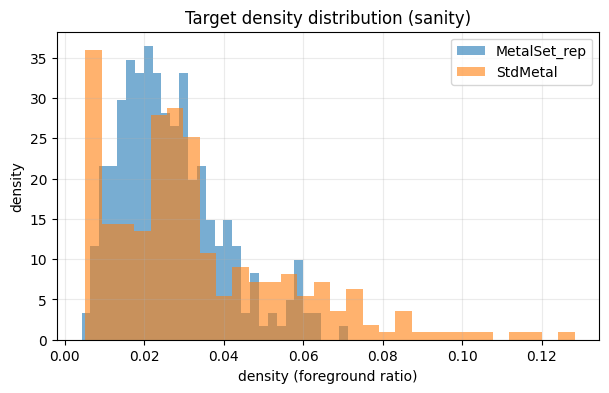

MetalSet_rep density: mean/median = 0.02657546152487892 0.024169921875
StdMetal density:     mean/median = 0.033547151572589945 0.02752685546875


In [6]:
# Cell 2-2: 전체 density 분포 quick check (Step1로 자연스럽게 연결)
dens_m = [load_bin_target(p).mean() for p in man_metal_rep["target"].values]
dens_s = [load_bin_target(p).mean() for p in man_std["target"].values]

import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.hist(dens_m, bins=30, alpha=0.6, density=True, label="MetalSet_rep")
plt.hist(dens_s, bins=30, alpha=0.6, density=True, label="StdMetal")
plt.title("Target density distribution (sanity)")
plt.xlabel("density (foreground ratio)")
plt.ylabel("density")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

print("MetalSet_rep density: mean/median =", float(np.mean(dens_m)), float(np.median(dens_m)))
print("StdMetal density:     mean/median =", float(np.mean(dens_s)), float(np.median(dens_s)))


In [7]:
# Connected components는 scipy 있으면 가장 안정적/빠름
try:
    import scipy.ndimage as ndi
except ImportError as e:
    raise ImportError("scipy가 필요합니다. (pip install scipy)") from e

def boundary_length_4conn(b: np.ndarray) -> int:
    # 4-neighbor 경계 길이 proxy: 이웃과 값이 달라지는 횟수 합
    # (완전한 perimeter 계산은 아니지만, 비교 목적에서는 매우 안정적)
    dh = np.abs(b[:, 1:] - b[:, :-1]).sum()
    dv = np.abs(b[1:, :] - b[:-1, :]).sum()
    return int(dh + dv)

def n_connected_components(b: np.ndarray) -> int:
    # 8-connectivity
    struct = np.ones((3,3), dtype=np.uint8)
    labeled, n = ndi.label(b.astype(np.uint8), structure=struct)
    return int(n)

def compute_complexity_metrics(target_path: str) -> dict:
    b = load_bin_target(target_path)  # (H,W) uint8 0/1
    area = float(b.sum())
    density = float(area / b.size)

    perim = float(boundary_length_4conn(b))
    ncc = float(n_connected_components(b))

    # compactness inverse proxy: perimeter^2 / area (area=0 방지)
    compact_inv = float((perim * perim) / (area + 1e-6))

    # edge density: perimeter / total pixels (정규화)
    edge_density = float(perim / b.size)

    return {
        "density": density,
        "edge_density": edge_density,
        "n_components": ncc,
        "compact_inv": compact_inv,
        "area_px": area,
        "perim_proxy": perim
    }

def build_metrics_df(df: pd.DataFrame, label_name: str) -> pd.DataFrame:
    rows = []
    for i, r in df.iterrows():
        m = compute_complexity_metrics(r["target"])
        m["set"] = label_name
        m["base_id"] = r.get("base_id", f"idx_{i}")
        rows.append(m)
        if (i+1) % 50 == 0:
            print(f"[{label_name}] processed {i+1}/{len(df)}")
    return pd.DataFrame(rows)

metrics_metal = build_metrics_df(man_metal_rep, "MetalSet_rep")
metrics_std   = build_metrics_df(man_std, "StdMetal")

metrics_all = pd.concat([metrics_metal, metrics_std], ignore_index=True)
metrics_all.head()


[MetalSet_rep] processed 50/271
[MetalSet_rep] processed 100/271
[MetalSet_rep] processed 150/271
[MetalSet_rep] processed 200/271
[MetalSet_rep] processed 250/271
[StdMetal] processed 50/271
[StdMetal] processed 100/271
[StdMetal] processed 150/271
[StdMetal] processed 200/271
[StdMetal] processed 250/271


,density,edge_density,n_components,compact_inv,area_px,perim_proxy,set,base_id
0,0.035782,1.121094,4.0,2.301976e+06,2345.0,73472.0,MetalSet_rep,cell2867
1,0.035736,1.113281,4.0,2.272913e+06,2342.0,72960.0,MetalSet_rep,cell121
2,0.025681,0.800781,3.0,1.636453e+06,1683.0,52480.0,MetalSet_rep,cell5949
3,0.013840,0.437500,3.0,9.063766e+05,907.0,28672.0,MetalSet_rep,cell941
4,0.018646,0.554688,3.0,1.081398e+06,1222.0,36352.0,MetalSet_rep,cell3957


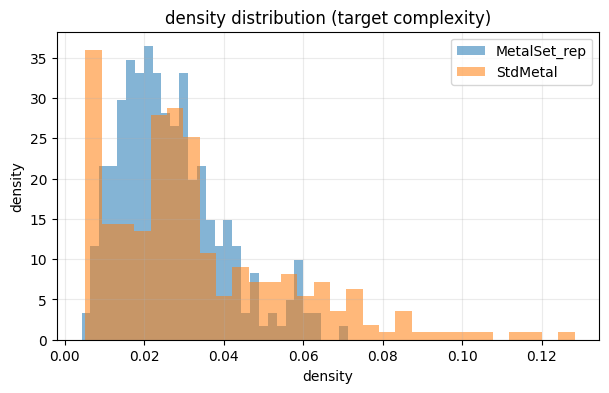

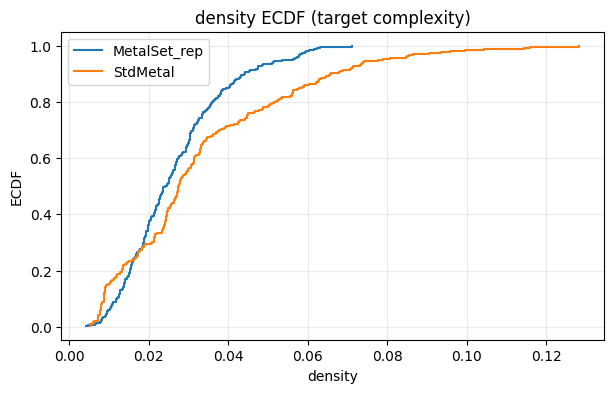

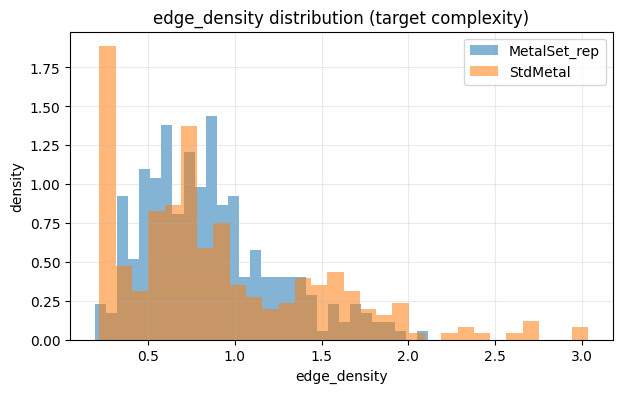

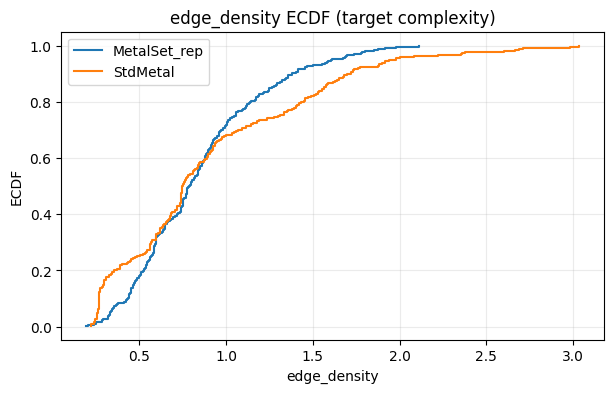

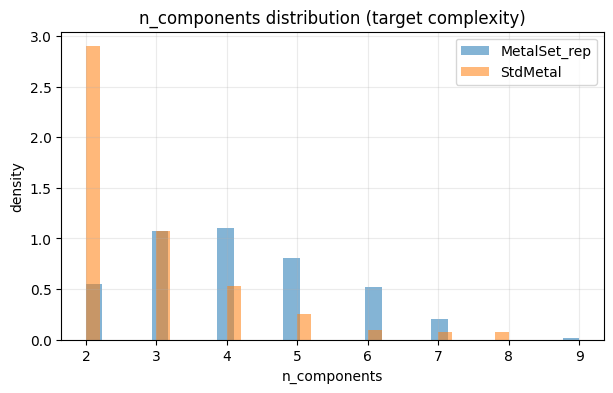

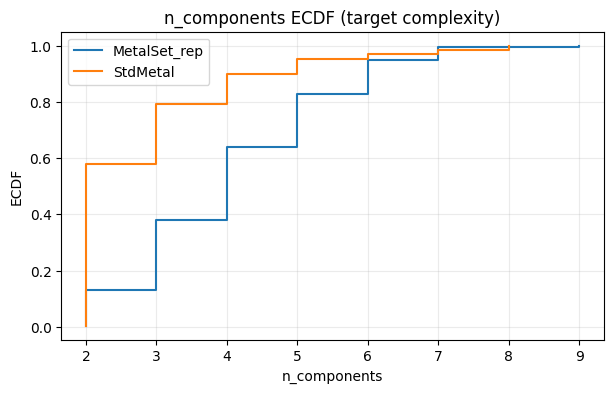

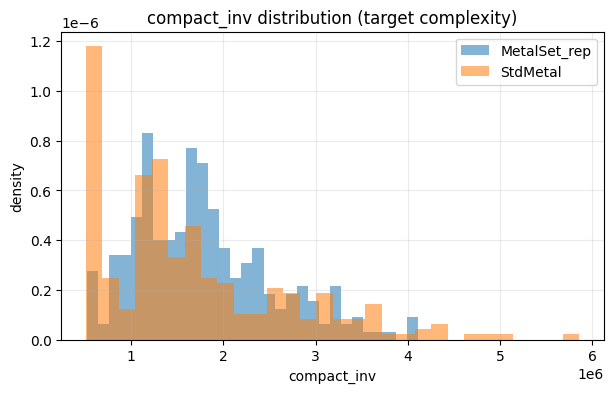

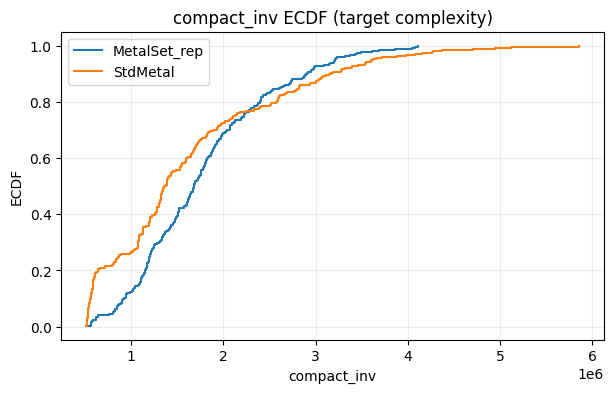

In [8]:
import matplotlib.pyplot as plt

def plot_hist_overlay(df, col, bins=30, title=""):
    a = df[df["set"]=="MetalSet_rep"][col].values
    b = df[df["set"]=="StdMetal"][col].values
    plt.figure(figsize=(7,4))
    plt.hist(a, bins=bins, alpha=0.55, label="MetalSet_rep", density=True)
    plt.hist(b, bins=bins, alpha=0.55, label="StdMetal", density=True)
    plt.title(title or f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("density")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.show()

def plot_ecdf(df, col, title=""):
    plt.figure(figsize=(7,4))
    for name in ["MetalSet_rep", "StdMetal"]:
        x = np.sort(df[df["set"]==name][col].values)
        y = np.arange(1, len(x)+1) / len(x)
        plt.step(x, y, where="post", label=name)
    plt.title(title or f"ECDF: {col}")
    plt.xlabel(col); plt.ylabel("ECDF")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.show()

for col in ["density", "edge_density", "n_components", "compact_inv"]:
    plot_hist_overlay(metrics_all, col, bins=30, title=f"{col} distribution (target complexity)")
    plot_ecdf(metrics_all, col, title=f"{col} ECDF (target complexity)")


In [9]:
try:
    from scipy.stats import ks_2samp, mannwhitneyu
except ImportError as e:
    raise ImportError("scipy.stats가 필요합니다. (pip install scipy)") from e

def cliffs_delta(x, y):
    # O(n*m)지만 여기선 271x271이라 충분
    x = np.asarray(x)
    y = np.asarray(y)
    gt = 0
    lt = 0
    for xi in x:
        gt += np.sum(xi > y)
        lt += np.sum(xi < y)
    return float((gt - lt) / (len(x)*len(y) + 1e-12))

def compare_metric(df, col):
    x = df[df["set"]=="MetalSet_rep"][col].values
    y = df[df["set"]=="StdMetal"][col].values

    ks = ks_2samp(x, y, alternative="two-sided", mode="auto")
    mw = mannwhitneyu(x, y, alternative="two-sided")
    cd = cliffs_delta(x, y)

    return {
        "metric": col,
        "Metal_mean": float(np.mean(x)),
        "Std_mean": float(np.mean(y)),
        "Metal_median": float(np.median(x)),
        "Std_median": float(np.median(y)),
        "KS_stat": float(ks.statistic),
        "KS_p": float(ks.pvalue),
        "MWU_stat": float(mw.statistic),
        "MWU_p": float(mw.pvalue),
        "Cliffs_delta": float(cd),
    }

results = pd.DataFrame([compare_metric(metrics_all, c) for c in ["density","edge_density","n_components","compact_inv"]])
results


,metric,Metal_mean,Std_mean,Metal_median,Std_median,KS_stat,KS_p,MWU_stat,MWU_p,Cliffs_delta
0,density,2.657546e-02,3.354715e-02,2.416992e-02,2.752686e-02,0.166052,1.113844e-03,32095.5,1.118684e-02,-0.125951
1,edge_density,8.488382e-01,9.143652e-01,7.851562e-01,7.460938e-01,0.151292,3.997347e-03,37211.0,7.880843e-01,0.013358
2,n_components,4.084871e+00,2.819188e+00,4.000000e+00,2.000000e+00,0.450185,4.154046e-25,56574.0,1.977229e-29,0.540665
3,compact_inv,1.788133e+06,1.659043e+06,1.682395e+06,1.351509e+06,0.191882,8.888849e-05,43009.0,5.619764e-04,0.171253


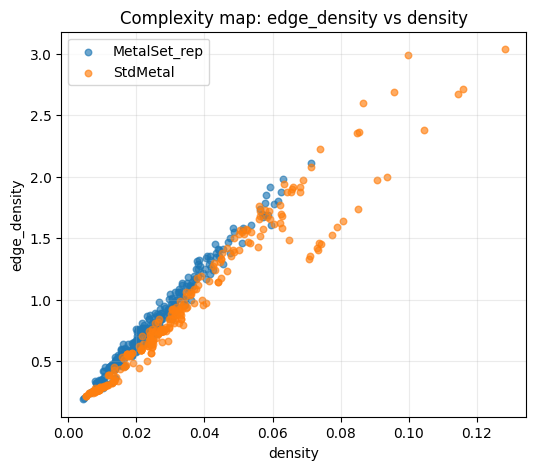

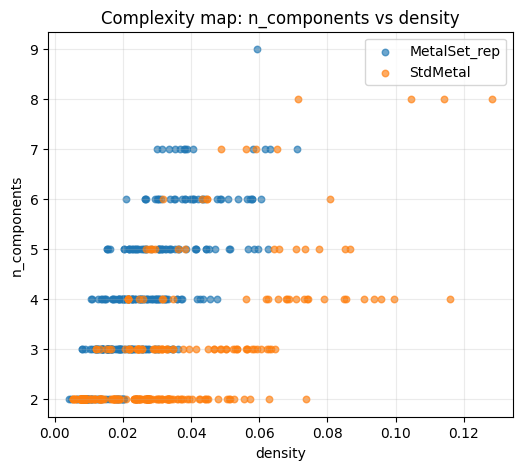

In [10]:
import matplotlib.pyplot as plt

def scatter_2d(df, xcol, ycol, title=""):
    plt.figure(figsize=(6,5))
    for name, alpha in [("MetalSet_rep", 0.65), ("StdMetal", 0.65)]:
        sub = df[df["set"]==name]
        plt.scatter(sub[xcol], sub[ycol], s=22, alpha=alpha, label=name)
    plt.title(title or f"{ycol} vs {xcol}")
    plt.xlabel(xcol); plt.ylabel(ycol)
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.show()

scatter_2d(metrics_all, "density", "edge_density", "Complexity map: edge_density vs density")
scatter_2d(metrics_all, "density", "n_components", "Complexity map: n_components vs density")


In [11]:
# Step1→Step2 연결을 위한 최소 통제: n_components ~ density 통제 후에도 set 차이가 남는지
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
import statsmodels.api as sm

df = metrics_all.copy()
df["is_metal"] = (df["set"]=="MetalSet_rep").astype(int)

# 1) 선형 통제(해석 쉬움): n_components = a + b*density + c*is_metal
X = sm.add_constant(df[["density","is_metal"]])
y = df["n_components"].astype(float)
model = sm.OLS(y, X).fit()
print(model.summary().tables[1])  # is_metal 계수의 p-value 확인

# 2) density 구간(사분위)별로 MWU (비모수, 발표용으로 직관적)
df["dens_bin"] = pd.qcut(df["density"], q=4, duplicates="drop")
for b in df["dens_bin"].cat.categories:
    sub = df[df["dens_bin"]==b]
    x = sub[sub["set"]=="MetalSet_rep"]["n_components"].values
    y = sub[sub["set"]=="StdMetal"]["n_components"].values
    if len(x) > 5 and len(y) > 5:
        p = mannwhitneyu(x,y,alternative="two-sided").pvalue
        print(f"{b}: MWU p={p:.3e}, med(Metal)={np.median(x):.2f}, med(Std)={np.median(y):.2f}")


                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3038      0.102     12.756      0.000       1.103       1.505
density       45.1724      2.392     18.886      0.000      40.474      49.871
is_metal       1.5806      0.091     17.353      0.000       1.402       1.760
(0.00326, 0.0168]: MWU p=1.071e-11, med(Metal)=3.00, med(Std)=2.00
(0.0168, 0.0264]: MWU p=8.877e-11, med(Metal)=4.00, med(Std)=2.00
(0.0264, 0.0369]: MWU p=1.576e-15, med(Metal)=4.00, med(Std)=2.00
(0.0369, 0.128]: MWU p=1.574e-11, med(Metal)=6.00, med(Std)=3.00


## step2

In [12]:
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

SEED = 42
rng = np.random.default_rng(SEED)

ROOT = Path(".")
EXT = ".png"

SET_B = "StdMetal"
SET_A = "MetalSet"

DS_SIZE = 256
BIN_THR_TARGET = 0.5
BIN_THR_PRINTED = 0.5  # 먼저 0.5로 두고, Cell S2-1에서 sanity로 확인

# --- utils (Step1과 동일) ---
def load_gray(path: Path) -> np.ndarray:
    img = Image.open(path).convert("L")
    arr = np.asarray(img, dtype=np.float32)
    if arr.max() > 1.0:
        arr /= 255.0
    return arr

def downsample_nearest(bin_img: np.ndarray, size=256) -> np.ndarray:
    pil = Image.fromarray((bin_img * 255).astype(np.uint8))
    pil = pil.resize((size, size), resample=Image.NEAREST)
    return (np.asarray(pil) > 0).astype(np.uint8)

def binarize_fixed(x: np.ndarray, thr=0.5, auto_invert=True) -> np.ndarray:
    b = (x >= thr).astype(np.uint8)
    if auto_invert and b.mean() > 0.5:
        b = 1 - b
    return b

def list_ids(set_dir: Path, mod: str) -> set:
    paths = list((set_dir / mod).rglob(f"*{EXT}"))
    return {p.stem for p in paths}

def build_manifest(set_name: str, mods=("target","printed")) -> pd.DataFrame:
    set_dir = ROOT / set_name
    id_sets = {m: list_ids(set_dir, m) for m in mods}
    common = set.intersection(*[id_sets[m] for m in mods])
    rows = []
    for bid in sorted(common):
        row = {"set": set_name, "base_id": bid}
        for m in mods:
            row[m] = str(set_dir / m / f"{bid}{EXT}")
        rows.append(row)
    return pd.DataFrame(rows)

def load_bin(path_str: str, thr=0.5, size=256) -> np.ndarray:
    x = load_gray(Path(path_str))
    b = binarize_fixed(x, thr, auto_invert=True)
    b = downsample_nearest(b, size=size)
    return b

# --- MetalSet 대표 271 csv 읽기 ---
rep_csv = ROOT / "manifest_MetalSet_rep271_PCA_UMAP_KMeans.csv"
man_metal_rep = pd.read_csv(rep_csv)

# 대표 csv에 printed가 없으면, base_id로 MetalSet/printed를 붙여준다
metal_printed_dir = ROOT / SET_A / "printed"
if "printed" not in man_metal_rep.columns:
    man_metal_rep["printed"] = man_metal_rep["base_id"].apply(lambda x: str(metal_printed_dir / f"{x}{EXT}"))

# 실제 존재하는지 체크해서 누락 제거
exists_t = man_metal_rep["target"].apply(lambda p: Path(p).exists())
exists_p = man_metal_rep["printed"].apply(lambda p: Path(p).exists())
print("MetalSet_rep target exists:", exists_t.mean(), "printed exists:", exists_p.mean())
man_metal_rep = man_metal_rep[exists_t & exists_p].reset_index(drop=True)

# --- StdMetal: target+printed 교집합 manifest 생성 ---
man_std_tp = build_manifest(SET_B, mods=("target","printed"))

print("MetalSet_rep usable pairs:", len(man_metal_rep))
print("StdMetal usable pairs:", len(man_std_tp))

# Step2 비교는 표본수 차이가 있으면 해석이 꼬이므로, 양쪽을 min(n)으로 맞춤(옵션)
n_pair = min(len(man_metal_rep), len(man_std_tp))
man_metal_s2 = man_metal_rep.sample(n_pair, random_state=SEED).reset_index(drop=True)
man_std_s2   = man_std_tp.sample(n_pair, random_state=SEED).reset_index(drop=True)
print("Using n_pair per set:", n_pair)


MetalSet_rep target exists: 1.0 printed exists: 0.996309963099631
MetalSet_rep usable pairs: 270
StdMetal usable pairs: 271
Using n_pair per set: 270


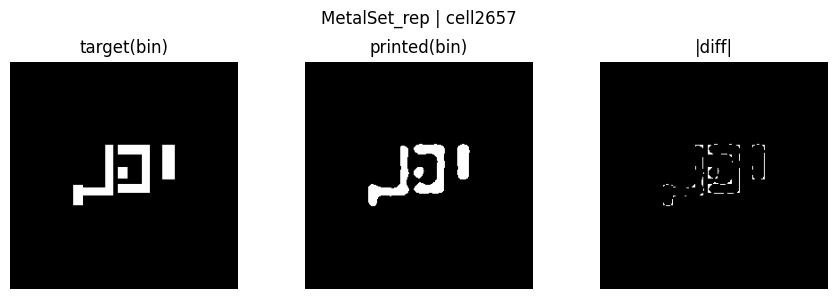

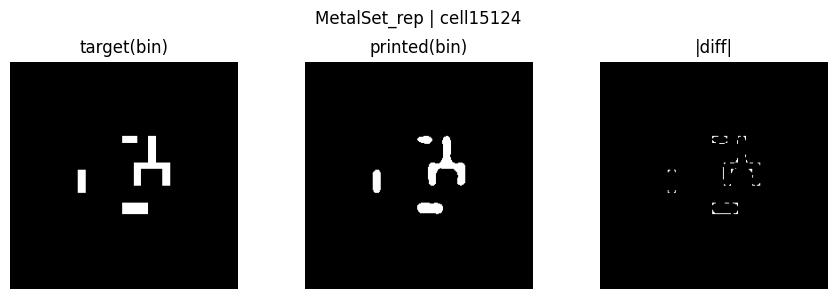

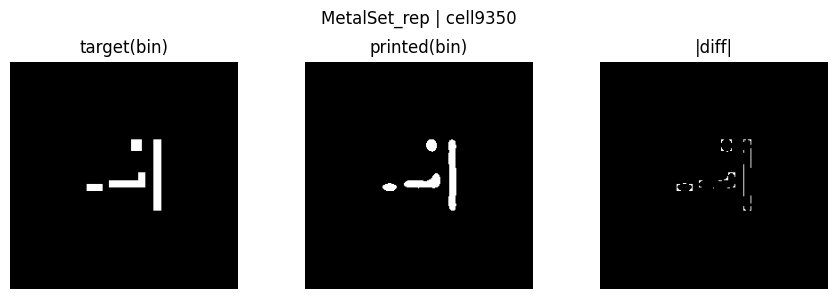

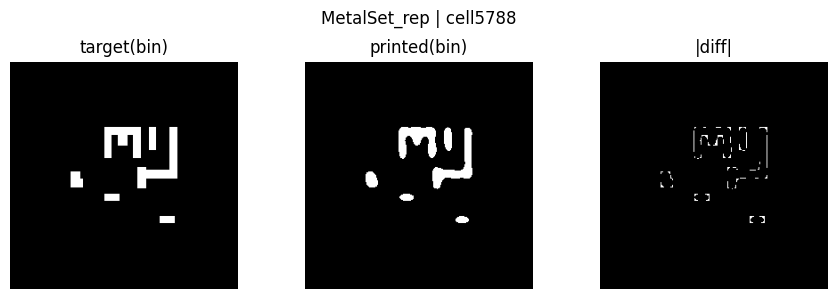

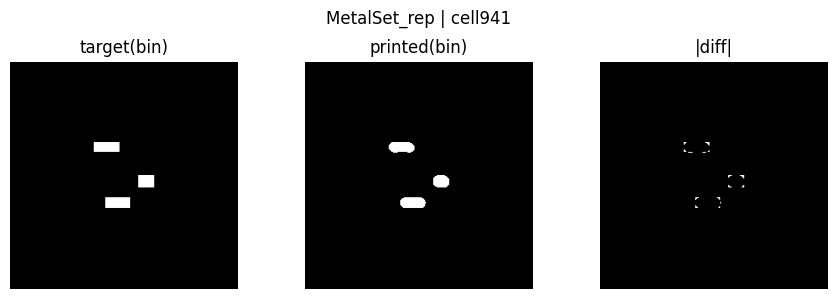

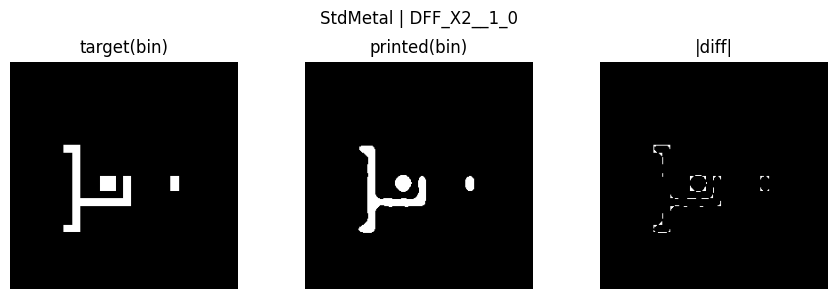

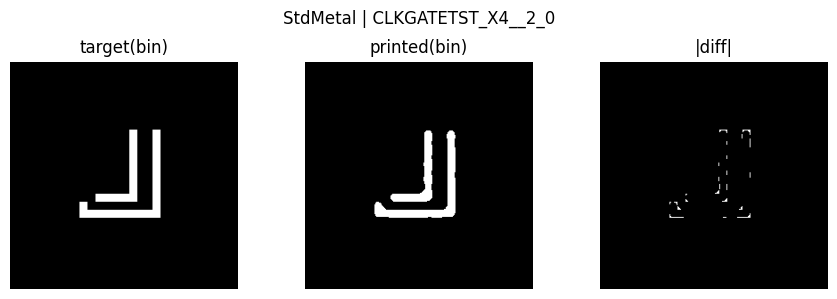

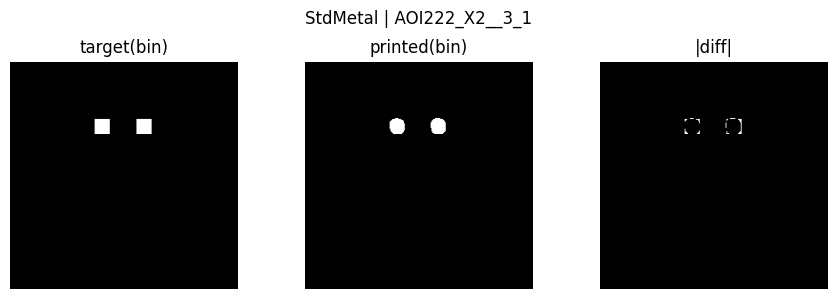

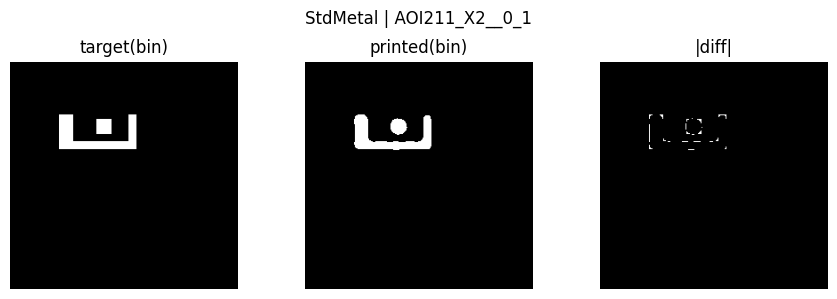

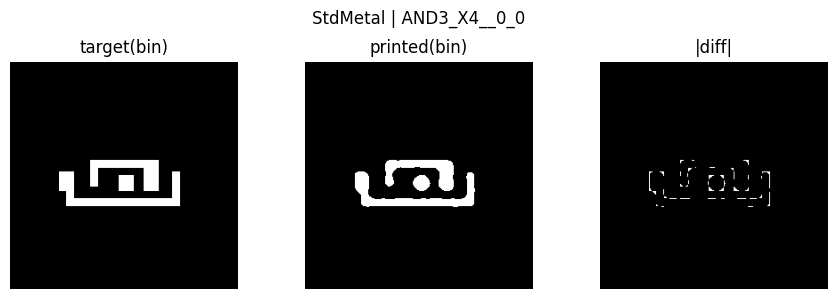

In [13]:
def show_pairs(df, k=5, title=""):
    samp = df.sample(min(k, len(df)), random_state=SEED)
    for _, r in samp.iterrows():
        t = load_bin(r["target"], thr=BIN_THR_TARGET, size=DS_SIZE)
        p = load_bin(r["printed"], thr=BIN_THR_PRINTED, size=DS_SIZE)

        fig, ax = plt.subplots(1,3, figsize=(9,3))
        ax[0].imshow(t, cmap="gray"); ax[0].set_title("target(bin)"); ax[0].axis("off")
        ax[1].imshow(p, cmap="gray"); ax[1].set_title("printed(bin)"); ax[1].axis("off")
        ax[2].imshow(np.abs(p.astype(int)-t.astype(int)), cmap="gray"); ax[2].set_title("|diff|"); ax[2].axis("off")
        plt.suptitle(f"{title} | {r['base_id']}")
        plt.tight_layout()
        plt.show()

show_pairs(man_metal_s2, k=5, title="MetalSet_rep")
show_pairs(man_std_s2, k=5, title="StdMetal")


In [14]:
try:
    import scipy.ndimage as ndi
except ImportError as e:
    raise ImportError("scipy 필요: pip install scipy") from e

def iou(p: np.ndarray, t: np.ndarray) -> float:
    inter = np.logical_and(p==1, t==1).sum()
    union = np.logical_or(p==1, t==1).sum()
    return float(inter / (union + 1e-12))

def over_under_rates(p: np.ndarray, t: np.ndarray):
    # over: printed=1, target=0 (브리징/먹힘류)
    # under: printed=0, target=1 (오픈/끊김류)
    over = np.logical_and(p==1, t==0).sum()
    under = np.logical_and(p==0, t==1).sum()
    denom = t.size
    return float(over/denom), float(under/denom)

def boundary_f1(p: np.ndarray, t: np.ndarray, band=1) -> float:
    # 1px boundary band 기준의 F1
    # 경계는 이웃차이로 추출(간단/안정)
    def boundary(mask):
        dh = np.zeros_like(mask); dv = np.zeros_like(mask)
        dh[:,1:] = mask[:,1:] != mask[:,:-1]
        dv[1:,:] = mask[1:,:] != mask[:-1,:]
        return (dh | dv).astype(np.uint8)

    bp = boundary(p.astype(bool))
    bt = boundary(t.astype(bool))

    # band dilation으로 약간의 위치 오차 허용(리소에서 흔한 오프셋 대응)
    struct = np.ones((2*band+1, 2*band+1), dtype=np.uint8)
    bt_d = ndi.binary_dilation(bt, structure=struct)
    bp_d = ndi.binary_dilation(bp, structure=struct)

    tp = np.logical_and(bp==1, bt_d==1).sum()
    fp = np.logical_and(bp==1, bt_d==0).sum()
    fn = np.logical_and(bt==1, bp_d==0).sum()

    prec = tp / (tp+fp+1e-12)
    rec  = tp / (tp+fn+1e-12)
    return float(2*prec*rec / (prec+rec+1e-12))


In [15]:
def compute_step2_metrics(df: pd.DataFrame, set_label: str) -> pd.DataFrame:
    rows = []
    for i, r in df.iterrows():
        t = load_bin(r["target"], thr=BIN_THR_TARGET, size=DS_SIZE)
        p = load_bin(r["printed"], thr=BIN_THR_PRINTED, size=DS_SIZE)

        iou_v = iou(p,t)
        over_v, under_v = over_under_rates(p,t)
        bf1_v = boundary_f1(p,t, band=1)

        rows.append({
            "set": set_label,
            "base_id": r["base_id"],
            "iou": iou_v,
            "over_rate": over_v,
            "under_rate": under_v,
            "boundary_f1": bf1_v,
        })
        if (i+1) % 50 == 0:
            print(f"[{set_label}] processed {i+1}/{len(df)}")
    return pd.DataFrame(rows)

m_metal = compute_step2_metrics(man_metal_s2, "MetalSet_rep")
m_std   = compute_step2_metrics(man_std_s2, "StdMetal")

m_all = pd.concat([m_metal, m_std], ignore_index=True)
m_all.head()


[MetalSet_rep] processed 50/270
[MetalSet_rep] processed 100/270
[MetalSet_rep] processed 150/270
[MetalSet_rep] processed 200/270
[MetalSet_rep] processed 250/270
[StdMetal] processed 50/270
[StdMetal] processed 100/270
[StdMetal] processed 150/270
[StdMetal] processed 200/270
[StdMetal] processed 250/270


,set,base_id,iou,over_rate,under_rate,boundary_f1
0,MetalSet_rep,cell5704,0.894942,0.000626,0.002258,0.975962
1,MetalSet_rep,cell12512,0.922027,0.000183,0.001038,0.976321
2,MetalSet_rep,cell10267,0.844508,0.000443,0.001221,0.933333
3,MetalSet_rep,cell16516,0.847991,0.000168,0.001968,0.949580
4,MetalSet_rep,cell5562,0.843738,0.000656,0.005417,0.914043


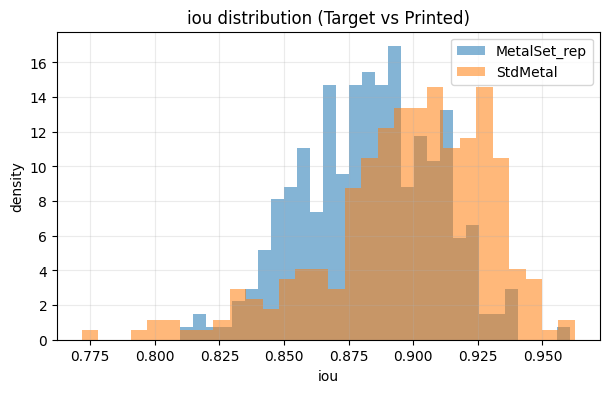

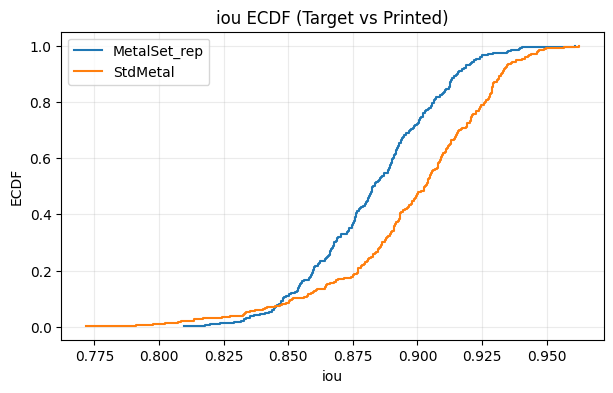

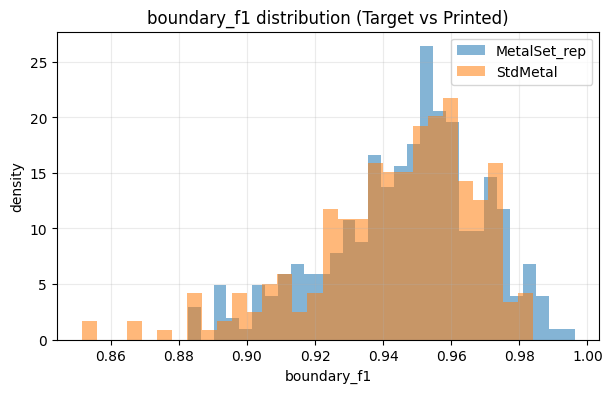

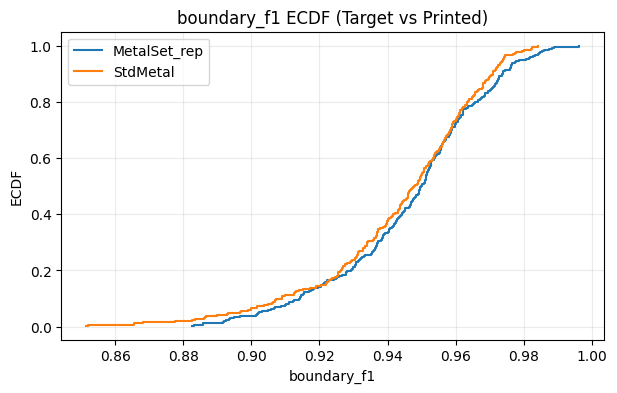

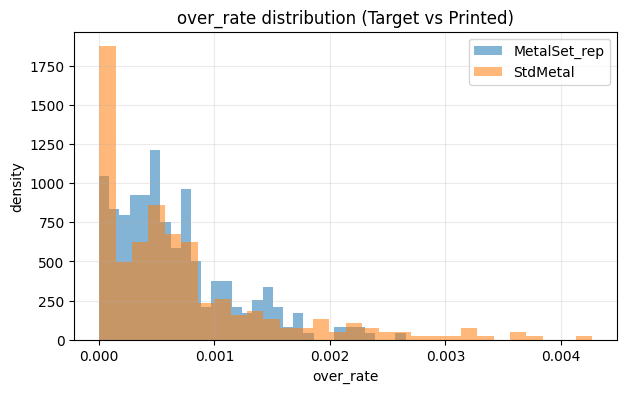

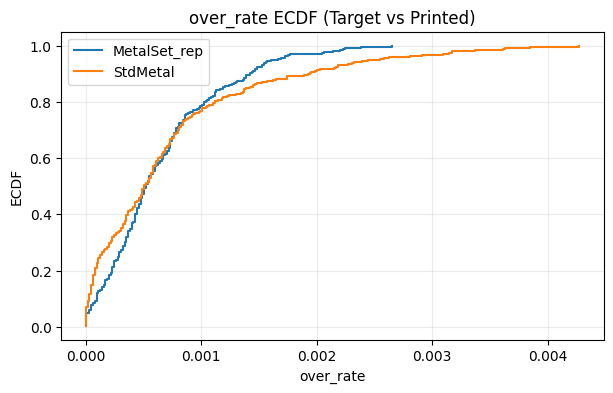

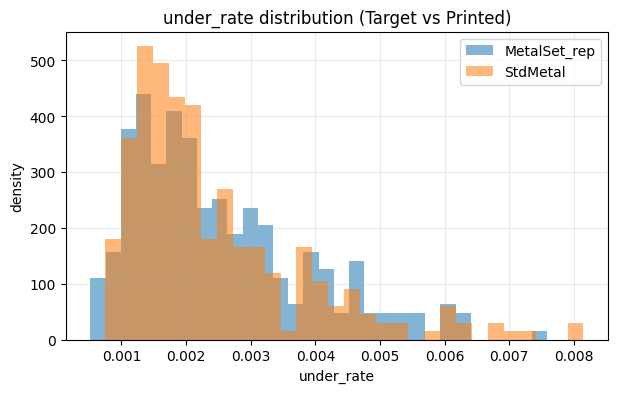

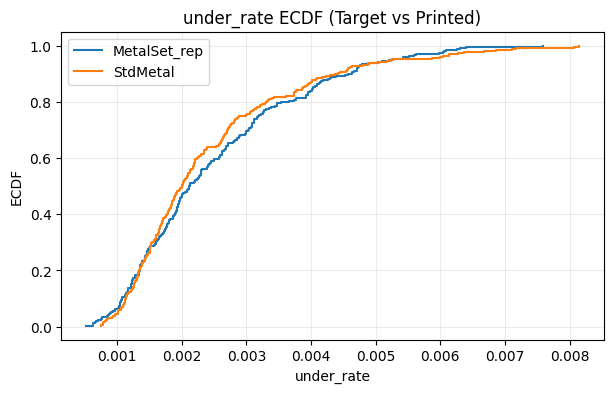

In [16]:
def plot_hist_overlay(df, col, bins=30, title=""):
    a = df[df["set"]=="MetalSet_rep"][col].values
    b = df[df["set"]=="StdMetal"][col].values
    plt.figure(figsize=(7,4))
    plt.hist(a, bins=bins, alpha=0.55, label="MetalSet_rep", density=True)
    plt.hist(b, bins=bins, alpha=0.55, label="StdMetal", density=True)
    plt.title(title or f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("density")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.show()

def plot_ecdf(df, col, title=""):
    plt.figure(figsize=(7,4))
    for name in ["MetalSet_rep","StdMetal"]:
        x = np.sort(df[df["set"]==name][col].values)
        y = np.arange(1, len(x)+1)/len(x)
        plt.step(x,y,where="post",label=name)
    plt.title(title or f"ECDF: {col}")
    plt.xlabel(col); plt.ylabel("ECDF")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.show()

for col in ["iou","boundary_f1","over_rate","under_rate"]:
    plot_hist_overlay(m_all, col, bins=30, title=f"{col} distribution (Target vs Printed)")
    plot_ecdf(m_all, col, title=f"{col} ECDF (Target vs Printed)")


In [17]:
from scipy.stats import ks_2samp, mannwhitneyu

def cliffs_delta(x, y):
    x = np.asarray(x); y = np.asarray(y)
    gt = 0; lt = 0
    for xi in x:
        gt += np.sum(xi > y)
        lt += np.sum(xi < y)
    return float((gt - lt) / (len(x)*len(y) + 1e-12))

def compare_metric(df, col):
    x = df[df["set"]=="MetalSet_rep"][col].values
    y = df[df["set"]=="StdMetal"][col].values
    ks = ks_2samp(x,y)
    mw = mannwhitneyu(x,y,alternative="two-sided")
    cd = cliffs_delta(x,y)
    return {
        "metric": col,
        "Metal_mean": float(np.mean(x)),
        "Std_mean": float(np.mean(y)),
        "Metal_median": float(np.median(x)),
        "Std_median": float(np.median(y)),
        "KS_stat": float(ks.statistic),
        "KS_p": float(ks.pvalue),
        "MWU_p": float(mw.pvalue),
        "Cliffs_delta": float(cd),
    }

step2_results = pd.DataFrame([compare_metric(m_all, c) for c in ["iou","boundary_f1","over_rate","under_rate"]])
step2_results


,metric,Metal_mean,Std_mean,Metal_median,Std_median,KS_stat,KS_p,MWU_p,Cliffs_delta
0,iou,0.883071,0.897721,0.883123,0.903141,0.277778,1.414295e-09,1.895407e-11,-0.333937
1,boundary_f1,0.946533,0.943409,0.949880,0.948005,0.059259,7.312385e-01,2.734238e-01,0.054486
2,over_rate,0.000652,0.000731,0.000519,0.000504,0.125926,2.755029e-02,3.379051e-01,0.047668
3,under_rate,0.002510,0.002438,0.002121,0.001999,0.074074,4.499552e-01,3.555071e-01,0.045967


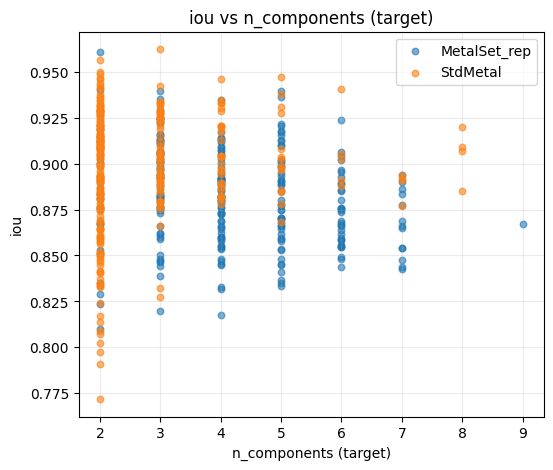

MetalSet_rep: Spearman rho=-0.252, p=2.889e-05
StdMetal: Spearman rho=0.096, p=1.169e-01


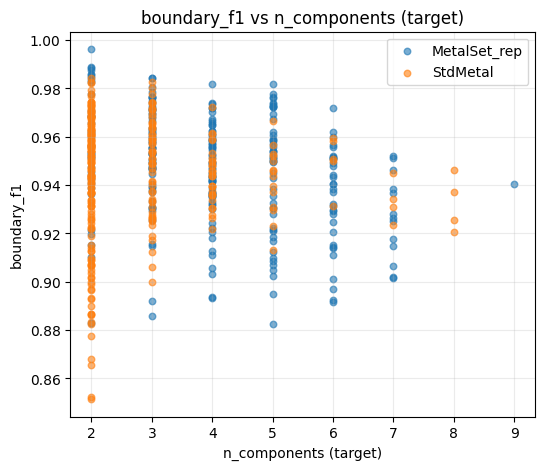

MetalSet_rep: Spearman rho=-0.339, p=1.146e-08
StdMetal: Spearman rho=-0.061, p=3.208e-01


In [18]:
# Step1에서 만들었던 compute_complexity_metrics가 있다면 재사용 가능.
# 없으면 Step2용으로 최소 n_components만 다시 계산.

def n_connected_components(b: np.ndarray) -> int:
    struct = np.ones((3,3), dtype=np.uint8)
    _, n = ndi.label(b.astype(np.uint8), structure=struct)
    return int(n)

def add_target_components(df_pairs: pd.DataFrame) -> pd.DataFrame:
    comps = []
    for i, r in df_pairs.iterrows():
        t = load_bin(r["target"], thr=BIN_THR_TARGET, size=DS_SIZE)
        comps.append(n_connected_components(t))
    out = df_pairs[["base_id"]].copy()
    out["n_components"] = comps
    return out

# Metal/Std 각각에 대해 base_id 기준 merge
c_metal = add_target_components(man_metal_s2)
c_std   = add_target_components(man_std_s2)

m_metal2 = m_metal.merge(c_metal, on="base_id", how="left")
m_std2   = m_std.merge(c_std, on="base_id", how="left")
m_all2 = pd.concat([m_metal2, m_std2], ignore_index=True)

# Scatter + 간단한 상관(스피어만)
from scipy.stats import spearmanr

def scatter_perf_vs_comp(df, ycol):
    plt.figure(figsize=(6,5))
    for name in ["MetalSet_rep","StdMetal"]:
        sub = df[df["set"]==name]
        plt.scatter(sub["n_components"], sub[ycol], s=22, alpha=0.6, label=name)
    plt.title(f"{ycol} vs n_components (target)")
    plt.xlabel("n_components (target)")
    plt.ylabel(ycol)
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.show()

    # Spearman per set (비선형에도 강함)
    for name in ["MetalSet_rep","StdMetal"]:
        sub = df[df["set"]==name]
        rho, p = spearmanr(sub["n_components"], sub[ycol])
        print(f"{name}: Spearman rho={rho:.3f}, p={p:.3e}")

scatter_perf_vs_comp(m_all2, "iou")
scatter_perf_vs_comp(m_all2, "boundary_f1")


## step3